In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/review.zip /content/
!unzip /content/drive/MyDrive/review.zip -d /content/review/

Archive:  /content/drive/MyDrive/review.zip
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-005.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-007.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-011.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-015.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-027.png  
  inflating: /content/review/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-40

In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
import tensorflow
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/review.zip'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

100%|██████████| 369/369 [00:05<00:00, 67.71it/s]


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         3,842 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,333,506 (69.94 MB)

 Trainable params: 18,100,610 (69.05 MB)

 Non-trainable params: 232,896 (909.75 KB)

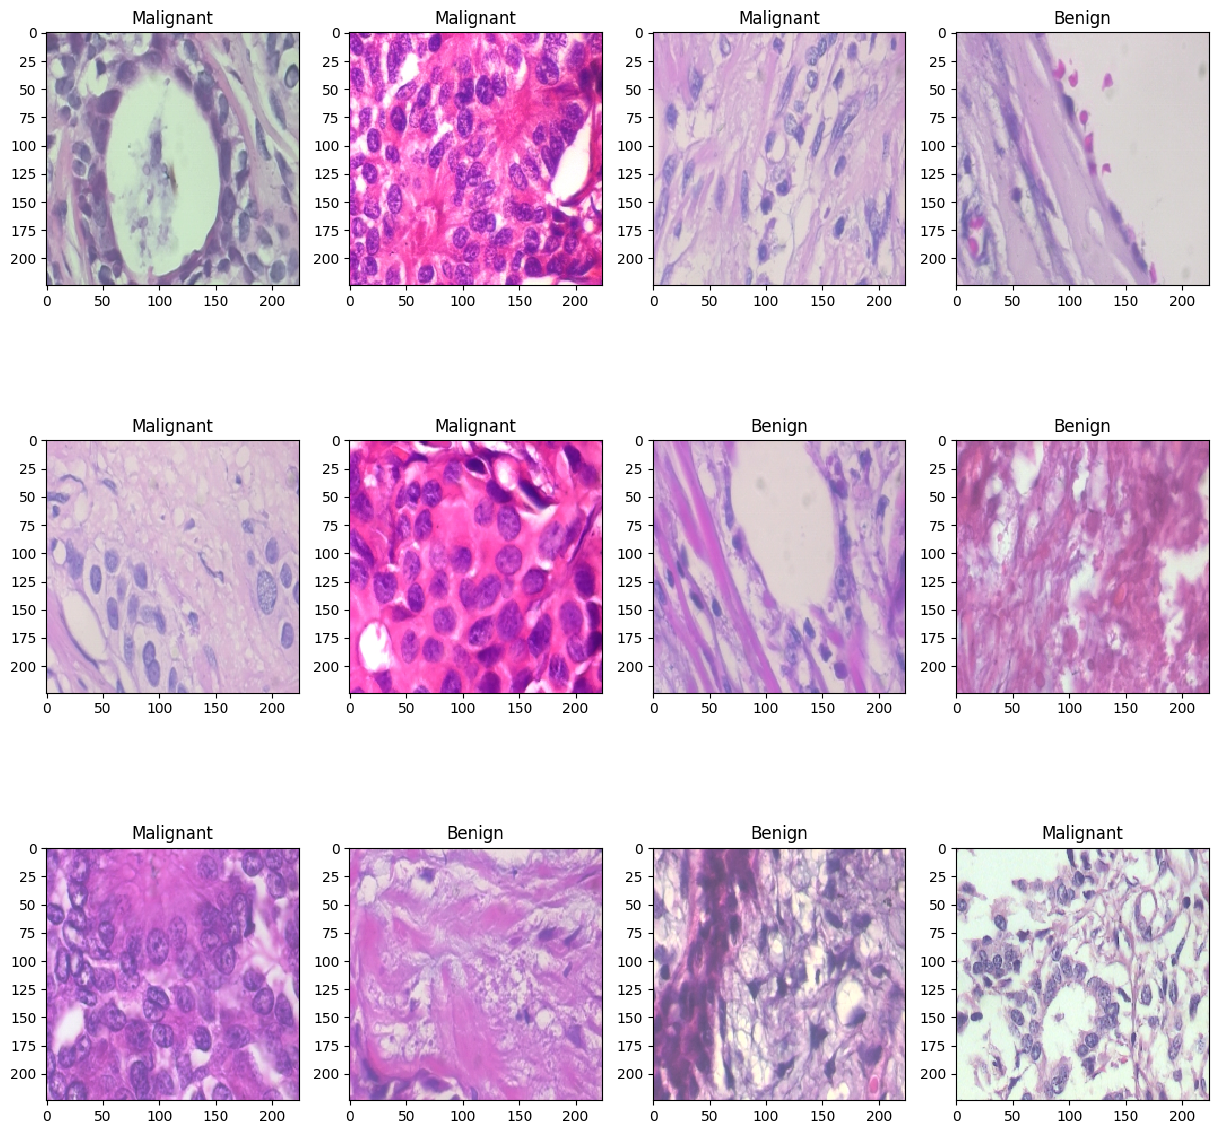

In [ ]:
benign_train = np.array(Dataset_loader('/content/review/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/review/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/review/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/review/BreaKHis 400X/test/malignant',224))
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11)
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')

BATCH_SIZE = 16
train_generator = ImageDataGenerator(
        zoom_range=2,
        rotation_range = 90,
        horizontal_flip=True,
        vertical_flip=True,
    )
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    return model
K.clear_session()
gc.collect()
result = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(result ,lr = 1e-4)
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.metrics import accuracy_score


filepath = '/content/drive/MyDrive/best_model.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=int(x_train.shape[0] / BATCH_SIZE),
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint]
)

model.load_weights(filepath)

Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8875 - loss: 0.3558 
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to /content/drive/MyDrive/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1066s 19s/step - accuracy: 0.8874 - loss: 0.3559 - val_accuracy: 0.7000 - val_loss: 0.6659
Epoch 2/5
 1/57 ━━━━━━━━━━━━━━━━━━━━ 20:15 22s/step - accuracy: 0.8125 - loss: 0.4748

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.70000 to 0.73043, saving model to /content/drive/MyDrive/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8125 - loss: 0.4748 - val_accuracy: 0.7304 - val_loss: 0.5975
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8564 - loss: 0.3854 
Epoch 3: val_accuracy improved from 0.73043 to 0.88261, saving model to /content/drive/MyDrive/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1079s 18s/step - accuracy: 0.8564 - loss: 0.3851 - val_accuracy: 0.8826 - val_loss: 0.3558
Epoch 4/5
 1/57 ━━━━━━━━━━━━━━━━━━━━ 19:06 20s/step - accuracy: 0.9375 - loss: 0.2314
Epoch 4: val_accuracy improved from 0.88261 to 0.89130, saving model to /content/drive/MyDrive/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9375 - loss: 0.2314 - val_accuracy: 0.8913 - val_loss: 0.3250
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8786 - loss: 0.3371 
Epoch 5: val_accuracy improved from 0.89130 to 0.93478, sav

0.9347826086956522

In [ ]:
resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         3,842 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,333,506 (69.94 MB)

 Trainable params: 18,100,610 (69.05 MB)

 Non-trainable params: 232,896 (909.75 KB)

<Axes: >

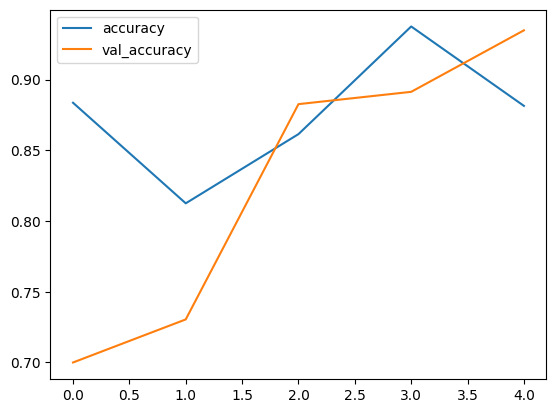

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

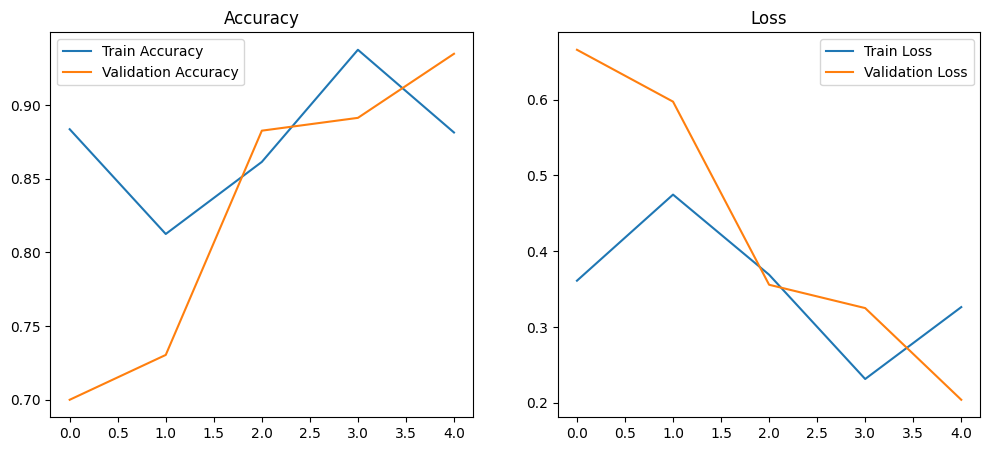

In [ ]:
# Model Evaluation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
model.load_weights("/content/drive/MyDrive/best_model.keras")

Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1214 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step


0.9347826086956522

18/18 ━━━━━━━━━━━━━━━━━━━━ 126s 7s/step


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step


 10%|█         | 1/10 [02:29<22:22, 149.22s/it]

34/34 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step


 20%|██        | 2/10 [04:46<18:59, 142.43s/it]

34/34 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step


 30%|███       | 3/10 [07:10<16:39, 142.85s/it]

34/34 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step


 40%|████      | 4/10 [09:24<13:56, 139.41s/it]

34/34 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step


 50%|█████     | 5/10 [11:35<11:21, 136.39s/it]

34/34 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step


 60%|██████    | 6/10 [13:45<08:57, 134.25s/it]

34/34 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step


 70%|███████   | 7/10 [15:56<06:39, 133.32s/it]

34/34 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step


 80%|████████  | 8/10 [18:06<04:24, 132.16s/it]

34/34 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step


 90%|█████████ | 9/10 [20:16<02:11, 131.37s/it]

34/34 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step


100%|██████████| 10/10 [22:26<00:00, 134.61s/it]


Confusion matrix, without normalization
[[139  37]
 [  8 361]]


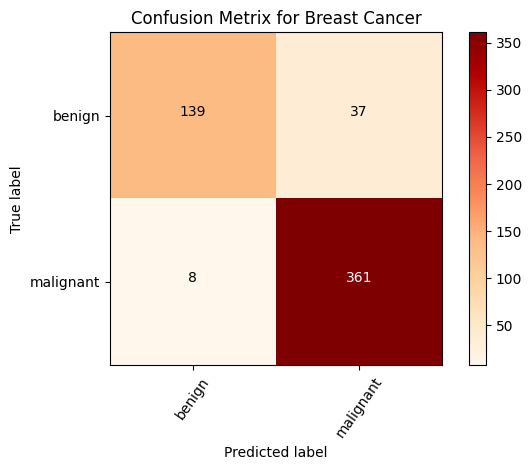

In [ ]:
Y_pred = model.predict(X_test)
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):

    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                         steps = len(X_test) // BATCH_SIZE)
    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap='OrRd')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

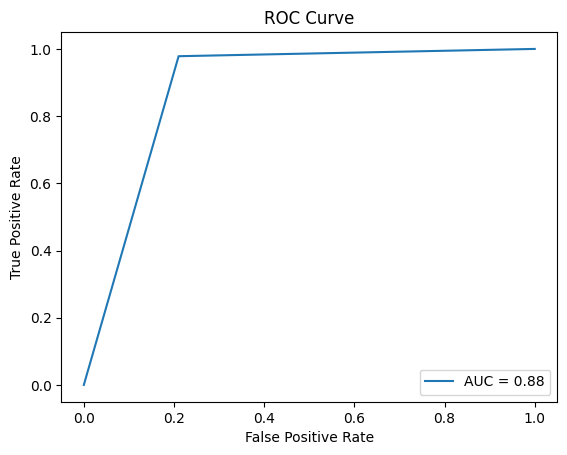

In [ ]:

from sklearn.metrics import roc_curve, auc


y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(Y_pred, axis=1)

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


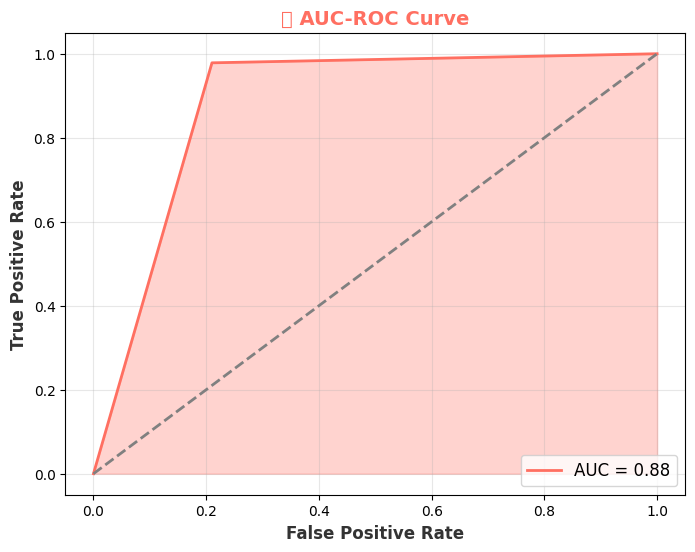

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='#FF6F61', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.fill_between(fpr, tpr, alpha=0.3, color='#FF6F61')


plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold', color='#333333')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold', color='#333333')
plt.title(' AUC-ROC Curve', fontsize=14, fontweight='bold', color='#FF6F61')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)


plt.show()